# MEAN-SQUARED ERROR AVEC UN MODELE XGBOOST

In [1]:
import pandas as pd
import numpy as np
import panel as pn

data = pd.read_csv('new_result_requetes.csv')

In [2]:
#On affecte le bon type aux variables qualitatives
data["city"]=pd.Categorical(data["city"],ordered=False)
data["language"]=pd.Categorical(data["language"],ordered=False)
data["group"]=pd.Categorical(data["group"],ordered=False)
data["brand"]=pd.Categorical(data["brand"],ordered=False)

data["mobile"]=pd.Categorical(data["mobile"],ordered=False)
data["parking"]=pd.Categorical(data["parking"],ordered=False)
data["pool"]=pd.Categorical(data["pool"],ordered=False)
data["children_policy"]=pd.Categorical(data["children_policy"],ordered=False)

data["hotel_id"]=pd.Categorical(data["hotel_id"],ordered=False)
data["avatar_id"]=pd.Categorical(data["avatar_id"],ordered=False)

data["price"]=pd.DataFrame(data["price"], dtype=float)

In [3]:
X = data[["nb_requete","date","stock","city","language","mobile","hotel_id","group","brand","parking","pool","children_policy"]]

In [4]:
Y = data[["price"]]

In [ ]:
#!pip install category_encoders > /dev/null 2>&1   EN LOCAL

In [5]:
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder, MEstimateEncoder, CatBoostEncoder
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [6]:
numerical_transformer = StandardScaler()
#categorical_transformer = OneHotEncoder()
#categorical_transformer = TargetEncoder()
categorical_transformer = MEstimateEncoder()
#categorical_transformer = CatBoostEncoder()

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("Standard_scaler", numerical_transformer, selector(dtype_exclude="category")),
        ("Cat_encoder", categorical_transformer, selector(dtype_include="category")),
    ]
)

In [8]:
pip = Pipeline(steps=[('Preprocessor', preprocessor),
                      #('Boosting', GradientBoostingRegressor()),
                      #('Boosting', HistGradientBoostingRegressor()),
                      ('Boosting', GradientBoostingRegressor(n_estimators=300,max_depth=10)),
                      #('Boosting', HistGradientBoostingRegressor(max_iter=1500,max_depth=75)),
                      ]
               )

In [9]:
pip

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('Standard_scaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f848753eeb0>),
                                                 ('Cat_encoder',
                                                  MEstimateEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8495360cd0>)])),
                ('Boosting',
                 GradientBoostingRegressor(max_depth=10, n_estimators=300))])

In [10]:
import matplotlib.pyplot as plt

## MSE en fonction de la date pour B folds

In [ ]:
date = np.linspace(0,44,45)
B = 10
Vect_erreur = np.zeros((B,len(date),2))

for b in range(0,B):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    pip.fit(X_train, y_train)
    pred = pip.predict(X_test)

    x = np.ravel(X_test[['date']])

    for i in range(len(x)):
        d = x[i]
        yt = y_test[i]
        p = pred[i]
        erreur = (yt-p)**2
        Vect_erreur[b,d,0] += erreur
        Vect_erreur[b,d,1] += 1

    for i in range(Vect_erreur.shape[1]):
        Vect_erreur[b,i,0] = Vect_erreur[b,i,0]/Vect_erreur[b,i,1] 

In [ ]:
arrayErreur = np.zeros((B,45))
for b in range(B):
    arrayErreur[b,:]=Vect_erreur[b,:,0]

In [ ]:
dataframeErreur = pd.DataFrame(arrayErreur)
plt.figure(figsize=(13,7))
dataframeErreur.boxplot()
plt.show()

## MSE en fonction de la ville pour B folds

In [ ]:
listCity = {'amsterdam':0, 'copenhagen':1, 'madrid':2, 'paris':3, 'rome':4, 'sofia':5, 'valletta':6, 'vienna':7, 'vilnius':8}
B = 10
Vect_erreur = np.zeros((B,len(listCity),2))

In [ ]:
for b in range(0,B):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    pip.fit(X_train, y_train)
    pred = pip.predict(X_test)

    x = np.ravel(X_test[['city']])
    
    for i in range(len(x)):
        c = x[i]
        yt = y_test[i]
        p = pred[i]
        erreur = (yt-p)**2
        Vect_erreur[b,listCity[c],0] += erreur
        Vect_erreur[b,listCity[c],1] += 1

    for i in range(Vect_erreur.shape[1]):
        Vect_erreur[b,i,0] = Vect_erreur[b,i,0]/Vect_erreur[b,i,1] 

In [ ]:
arrayErreur = np.zeros((B,len(listCity)))
for b in range(B):
    arrayErreur[b,:]=Vect_erreur[b,:,0]

In [ ]:
dataframeErreur = pd.DataFrame(arrayErreur,columns=['amsterdam', 'copenhagen', 'madrid', 'paris', 'rome', 'sofia', 'valletta', 'vienna', 'vilnius'])
plt.figure(figsize=(13,7))
dataframeErreur[['amsterdam', 'copenhagen', 'madrid', 'paris', 'rome', 'sofia', 'valletta', 'vienna', 'vilnius']].boxplot(return_type='dict')
plt.show()

## MSE en fonction du langage pour B folds

In [ ]:
listLang = {'austrian':0, 'belgian':1, 'bulgarian':2, 'croatian':3, 'cypriot':4, 'czech':5, 'danish':6, 'dutch':7, 'estonian':8, 'finnish':9,
            'french':10, 'german':11, 'greek':12, 'hungarian':13, 'irish':14, 'italian':15, 'latvian':16, 'lithuanian':17, 'luxembourgish':18, 
            'maltese':19, 'polish':20, 'portuguese':21, 'romanian':22, 'slovakian':23, 'slovene':24, 'spanish':25,'swedish':26}
B = 10
Vect_erreur = np.zeros((B,len(listLang),2))

In [ ]:
for b in range(0,B):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    pip.fit(X_train, y_train)
    pred = pip.predict(X_test)

    x = np.ravel(X_test[['language']])
    
    for i in range(len(x)):
        c = x[i]
        yt = y_test[i]
        p = pred[i]
        erreur = (yt-p)**2
        Vect_erreur[b,listLang[c],0] += erreur
        Vect_erreur[b,listLang[c],1] += 1

    for i in range(Vect_erreur.shape[1]):
        Vect_erreur[b,i,0] = Vect_erreur[b,i,0]/Vect_erreur[b,i,1] 

In [ ]:
arrayErreur = np.zeros((B,len(listLang)))
for b in range(B):
    arrayErreur[b,:]=Vect_erreur[b,:,0]

In [ ]:
dataframeErreur = pd.DataFrame(arrayErreur,columns=['austrian', 'belgian', 'bulgarian', 'croatian', 'cypriot', 'czech', 'danish', 'dutch', 'estonian', 'finnish',
            'french', 'german', 'greek', 'hungarian', 'irish', 'italian', 'latvian', 'lithuanian', 'luxembourgish', 
            'maltese', 'polish', 'portuguese', 'romanian', 'slovakian', 'slovene', 'spanish','swedish'])
plt.figure(figsize=(13,7))
dataframeErreur[['austrian', 'belgian', 'bulgarian', 'croatian', 'cypriot', 'czech', 'danish', 'dutch', 'estonian', 'finnish',
            'french', 'german', 'greek', 'hungarian', 'irish', 'italian', 'latvian', 'lithuanian', 'luxembourgish', 
            'maltese', 'polish', 'portuguese', 'romanian', 'slovakian', 'slovene', 'spanish','swedish']].boxplot(return_type='dict')
plt.show()

## MSE en fonction du nb de requêtes pour B folds

In [11]:
nr = np.linspace(1,7,7)
B = 10
Vect_erreur = np.zeros((B,len(nr),2))

for b in range(0,B):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    pip.fit(X_train, y_train)
    pred = pip.predict(X_test)

    x = np.ravel(X_test[['nb_requete']])

    for i in range(len(x)):
        n = x[i] - 1
        yt = y_test[i]
        p = pred[i]
        erreur = (yt-p)**2
        Vect_erreur[b,n,0] += erreur
        Vect_erreur[b,n,1] += 1

    for i in range(Vect_erreur.shape[1]):
        Vect_erreur[b,i,0] = Vect_erreur[b,i,0]/Vect_erreur[b,i,1] 

In [12]:
arrayErreur = np.zeros((B,7))
for b in range(B):
    arrayErreur[b,:]=Vect_erreur[b,:,0]

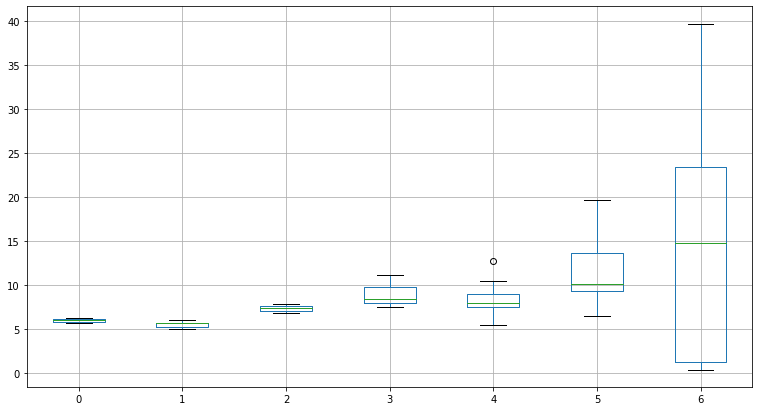

In [13]:
dataframeErreur = pd.DataFrame(arrayErreur)
plt.figure(figsize=(13,7))
dataframeErreur.boxplot()
plt.show()